# Outlier detection in market cap data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, glob
from pathlib import Path
import re
import json

In [2]:
# Loading data
df = pd.read_csv('processed_data/feature_data.csv', parse_dates=['date'])
market_cap = pd.read_csv('processed_data/target_data.csv', parse_dates=['date'])

### Function definitions

In [3]:
def get_ticker(df, name):
    cond = df['ticker'] == name
    return df.loc[cond].reset_index(drop=True)

In [4]:
def plot_outliers_rolling_median(data, variable, median_window, scale=1.5):
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), height_ratios=[1, 3])
    
    df = data.copy()
    
    bound_color = 'darkorange'
    med_color = 'red'
    data_color = 'blue'

    ax = axs[1]
    
    ax.plot('date', variable, data = df, color = data_color, label = variable, alpha=0.7)

    ax.set_xlabel('Date')
    ax.set_ylabel(variable.replace('_', ' ').capitalize())

    rolling = df.rolling(window=median_window, min_periods=1)[variable]
    roll_median = rolling.median()
    
    # Using 1.5*IQR for as a threshold
    iqr = rolling.quantile(0.75) - rolling.quantile(0.25)
    low_bound = rolling.quantile(0.25) - scale * iqr
    upp_bound = rolling.quantile(0.75) + scale * iqr

    df['roll_median'] = roll_median
    df['low_bound'] = low_bound
    df['upp_bound'] = upp_bound

    ax.plot('date', 'roll_median', data = df, color = med_color, label = 'Rolling median', alpha=0.5)
    ax.plot('date', 'low_bound', data = df, color = bound_color, label = 'Lower bound', alpha=0.5)
    ax.plot('date', 'upp_bound', data = df, color = bound_color, label = 'Upper bound', alpha=0.5)

    # Counting outliers
    cond1 = df[variable] > upp_bound
    cond2 = df[variable] < low_bound
    cond = cond1 | cond2
    total_outliers = cond.sum()
    graph = df[cond]

    # Checking if the first data is an outlier
    # Computing the 7 day median of the following weights
#     window = min(df.shape[0], median_window)
#     if np.abs(df.loc[0, variable] - df.loc[1:window, variable].median()) > threshold:
#         graph = graph.append(df.loc[0])
#         total_outliers += 1

    ax.scatter(x = 'date', y = variable, data = graph, marker = 'X',
             color = 'red', s = 100, label = 'Outlier')

    ax.legend(ncols=3)
    
    # Plotting market cap only
    ax = axs[0]
    ax.plot('date', variable, data=df, color='gray', alpha=0.6, label=variable)
    ax.scatter(x = 'date', y = variable, data = graph, marker = 'X',
                 color = 'red', s = 50, label = 'Outlier')
    ax.legend(ncols=2)
    
    ax.set_title(f"{variable.replace('_', ' ').capitalize()} - {total_outliers} outlier(s) detected")
    
    # Updating ax limits
    xmin, xmax = df['date'].min(), df['date'].max()
    for ax in axs:
        ax.set_xlim(xmin, xmax)
        
    return axs

In [22]:
def plot_outliers(data, variable, window, method='median', scale=1.5):
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 6), height_ratios=[1, 3])
    
    df = data.copy()
    
    bound_color = 'darkorange'
    med_color = 'red'
    data_color = 'blue'

    ax = axs[1]
    
    ax.plot('date', variable, data = df, color = data_color, label = variable, alpha=0.7)

    ax.set_xlabel('Date')
    ax.set_ylabel(variable.replace('_', ' ').capitalize())
    
    rolling = df.rolling(window=window, min_periods=1)[variable]
    
    if method == 'median':
        rolling_window = rolling.median()

        # Using scale*IQR for as a threshold
        iqr = rolling.quantile(0.75) - rolling.quantile(0.25)
        low_bound = rolling.quantile(0.25) - scale * iqr
        upp_bound = rolling.quantile(0.75) + scale * iqr
        
    elif method == 'mean':
        rolling_window = rolling.mean()
        threshold = scale * rolling.std()
        low_bound = rolling_window - threshold
        upp_bound = rolling_window + threshold
        
    else:
        return

        
    df['rolling'] = rolling_window
    df['low_bound'] = low_bound
    df['upp_bound'] = upp_bound
        

    ax.plot('date', 'rolling', data = df, color = med_color, label = f'Rolling {method}', alpha=0.5)
    ax.plot('date', 'low_bound', data = df, color = bound_color, label = 'Lower bound', alpha=0.5)
    ax.plot('date', 'upp_bound', data = df, color = bound_color, label = 'Upper bound', alpha=0.5)

    # Counting outliers
    cond1 = df[variable] > upp_bound
    cond2 = df[variable] < low_bound
    cond = cond1 | cond2
    total_outliers = cond.sum()
    graph = df[cond]

    # Checking if the first data is an outlier
    # Computing the 7 day median of the following weights
#     window = min(df.shape[0], median_window)
#     if np.abs(df.loc[0, variable] - df.loc[1:window, variable].median()) > threshold:
#         graph = graph.append(df.loc[0])
#         total_outliers += 1

    ax.scatter(x = 'date', y = variable, data = graph, marker = 'X',
             color = 'red', s = 100, label = 'Outlier')

    ax.legend(ncols=3)
    
    # Plotting market cap only
    ax = axs[0]
    ax.plot('date', variable, data=df, color='gray', alpha=0.6, label=variable)
    ax.scatter(x = 'date', y = variable, data = graph, marker = 'X',
                 color = 'red', s = 50, label = 'Outlier')
    ax.legend(ncols=2)
    
    ax.set_title(f"{variable.replace('_', ' ').capitalize()} - {total_outliers} outlier(s) detected")
    
    # Updating ax limits
    xmin, xmax = df['date'].min(), df['date'].max()
    for ax in axs:
        ax.set_xlim(xmin, xmax)
        
    return axs

In [23]:
def replace_outliers(data, variable, median_window, method='median', scale=1.5):
    
    df = data.copy()
    
    rolling = df.rolling(window=window, min_periods=1)[variable]
    
    if method == 'median':
        rolling_window = rolling.median()

        # Using scale*IQR for as a threshold
        iqr = rolling.quantile(0.75) - rolling.quantile(0.25)
        low_bound = rolling.quantile(0.25) - scale * iqr
        upp_bound = rolling.quantile(0.75) + scale * iqr
        
    elif method == 'mean':
        rolling_window = rolling.mean()
        threshold = scale * rolling.std()
        low_bound = rolling_window - threshold
        upp_bound = rolling_window + threshold
        
    else:
        return

    df['rolling'] = rolling_window
    df['low_bound'] = low_bound
    df['upp_bound'] = upp_bound

    # Counting outliers
    high_cond = df[variable] > upp_bound
    low_cond = df[variable] < low_bound
    cond = high_cond | low_cond
    total_outliers = cond.sum()
    
    # Replacing outliers
    df.loc[high_cond, variable] = df.loc[high_cond, 'upp_bound']
    df.loc[low_cond, variable] = df.loc[low_cond, 'low_bound']
    
    df = df.drop(columns=['rolling', 'low_bound', 'upp_bound'])
    
    return df, total_outliers

## Plotting lower and upper boundaries
The lower and upper bounds are defined using two different methods:

1. Median:
* **Lower bound = Q1 - scale \* IQR**
* **Upper bound = Q3 + scale \* IQR**

Where Q1 and Q3 are the first and third quartiles of the data in the rolling window, respectively. IQR is the inter-quartile range (Q3-Q1). scale is a user defined value (in boxplots it is 1.5).

2. Mean:
* **Lower bound = Mean - scale \* std**
* **Upper bound = Mean + scale \* std**



Some interesting cases:
* OZGYO
* ISYAT
* ISFIN
* LUKSK
* INTEM
* USAK

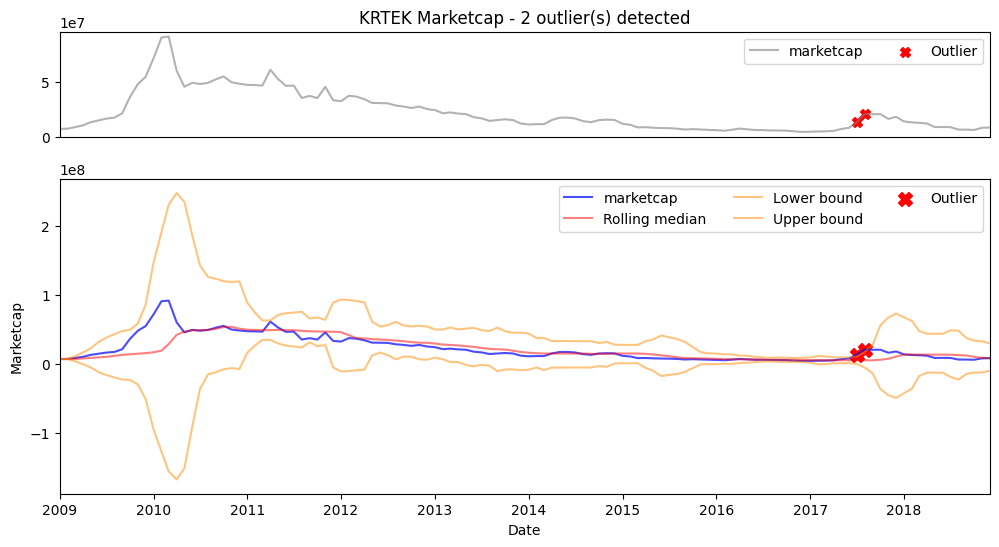

In [42]:
# Input

# Choose method "mean" or "median"
method = 'median'

# Define rolling window (number of months)
window = 12

# Define scale
scale = 4

# Either define ticker name manually or get a random ticker
# name = 'OZGYO'
name = np.random.choice(market_cap['ticker'].unique())

############################################

data = get_ticker(market_cap, name)

axs = plot_outliers(data, 'marketcap', window, method=method, scale=scale)

ax = axs[0]
title = ax.get_title()
ax.set_title(name + ' ' + title)
ax.set_xticks([])

plt.show()

### Counting the number of dropped outliers
Define a window size and scale to compute the total number of outliers dropped for each ticker.

In [43]:
# Input

# Choose method "mean" or "median"
method = 'median'

# Define rolling window (number of months)
window = 12

# Define scale
scale = 3

####################################

tickers = market_cap['ticker'].unique()

outlier_count = {}

for ticker in tickers:
    data = get_ticker(market_cap, ticker)
    new_data, total_outliers = replace_outliers(data, 'marketcap', window, method=method, scale=scale)
    outlier_count[ticker] = total_outliers
    
outlier_count = pd.DataFrame.from_dict(outlier_count, orient='index').reset_index()
outlier_count.columns = ['ticker', 'outlier_count']
outlier_count = outlier_count.sort_values(by='outlier_count', ascending=False).reset_index(drop=True)

total_dropped_outlier = outlier_count['outlier_count'].sum()
dropped_outlier_ratio = total_dropped_outlier / market_cap.shape[0]

print(f"Total number of outliers detected: {total_dropped_outlier}")
print(f"Percentage of outliers detected: {dropped_outlier_ratio:.2%}")

Total number of outliers detected: 566
Percentage of outliers detected: 2.19%


In [44]:
# Detected outliers by ticker
outlier_count.head()

,ticker,outlier_count
0,AFYON,9
1,ISATR,8
2,NETAS,8
3,OZGYO,7
4,KNFRT,7


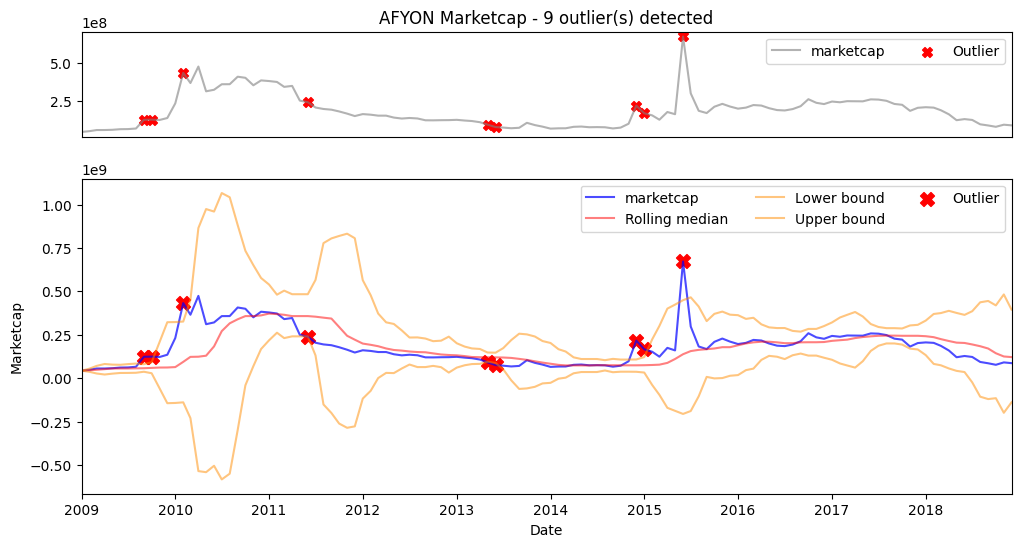

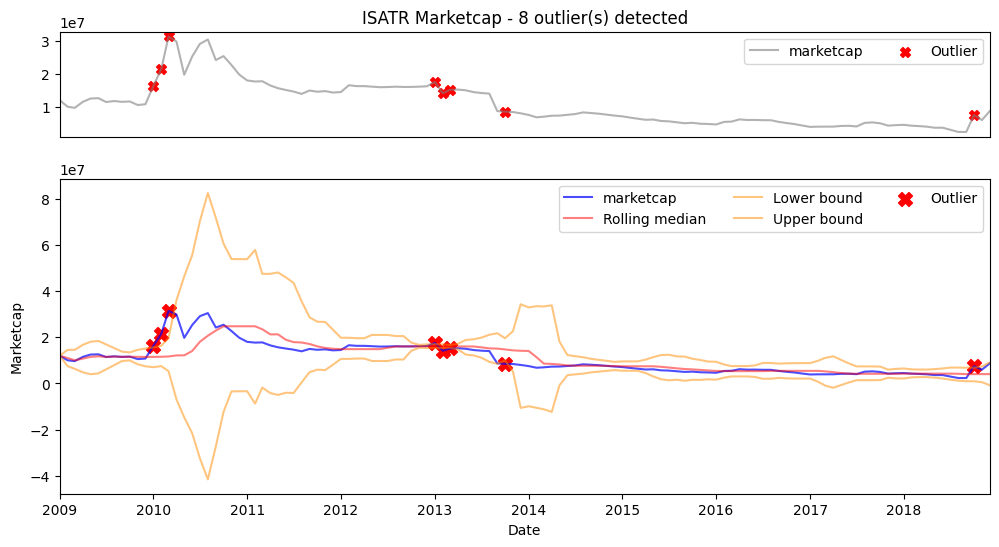

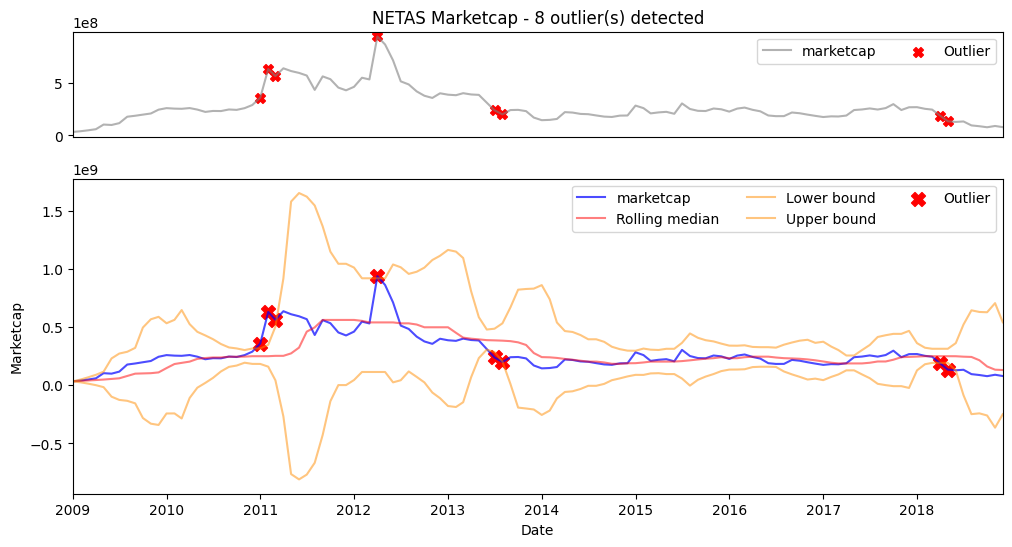

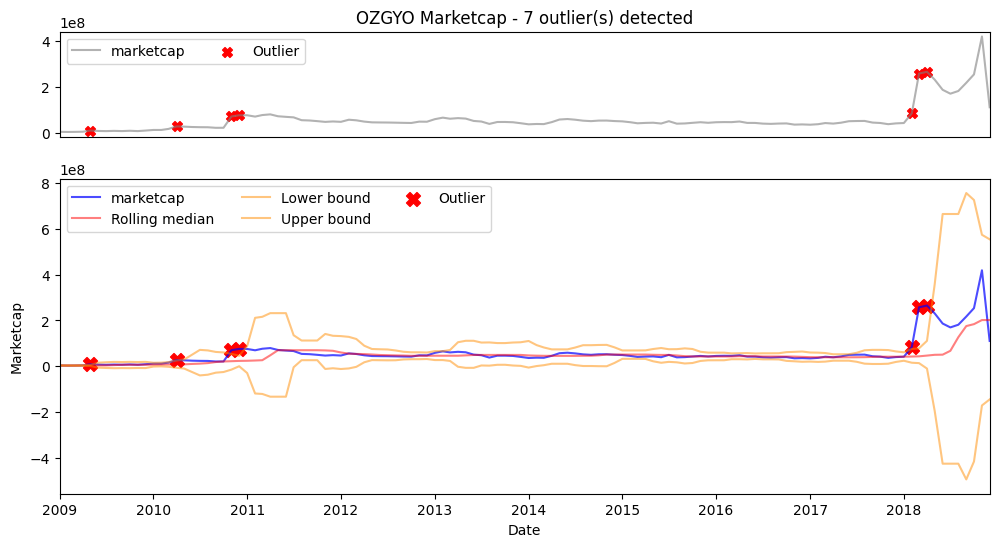

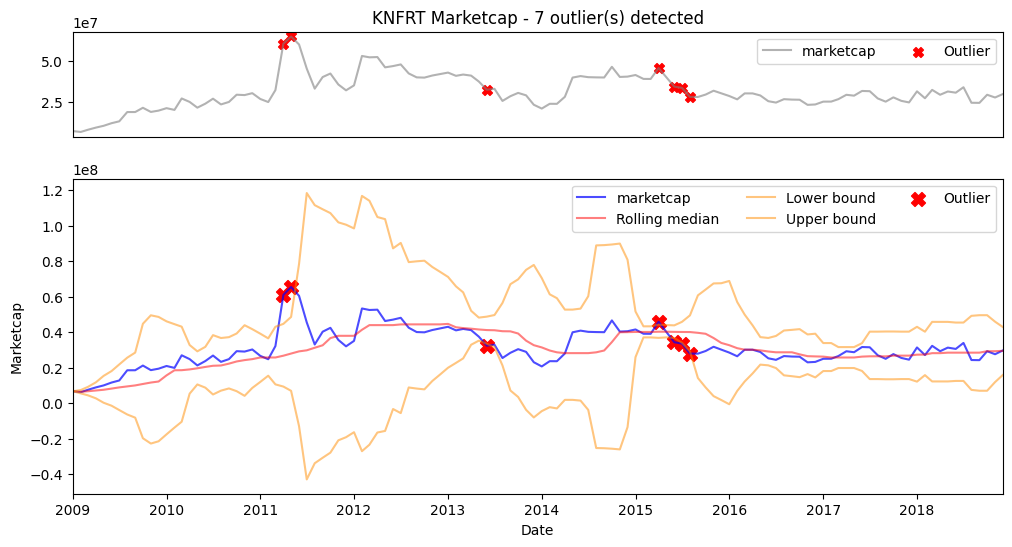

In [45]:
# Plotting some of the tickers with a lot of outliers
n = 5

tickers = outlier_count.loc[:n-1, 'ticker'].to_list()

for ticker in tickers:
    data = get_ticker(market_cap, ticker)
    axs = plot_outliers(data, 'marketcap', window, method, scale)
    ax = axs[0]
    title = ax.get_title()
    ax.set_title(ticker + ' ' + title)
    ax.set_xticks([])
    plt.show()